<script type="text/javascript" async
  src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML">
</script>


# Estadística bayesiana con Stan - 03 Modelo normal bivariado

En este notebook se presenta el uso de cmdstanpy para simular muestras de la distribución predictiva de un modelo simple para los parámetros de la distribución normal bivariada.

$$
\mathbf{y}_i \sim Normal_2(\boldsymbol{\mu}, \boldsymbol{\Sigma}), i = 1\ldots, n,
$$

con

$$
\boldsymbol{\mu} =
\begin{bmatrix}
\mu_{1} \\
\mu_{2}
\end{bmatrix}
$$

$$
\boldsymbol{\Sigma} =
\begin{bmatrix}
\sigma_{11} & \sigma_{12} \\
\sigma_{21} & \sigma^2_{22}
\end{bmatrix}.
$$

Descomponiendo $\boldsymbol{\Sigma}$ como $\boldsymbol{\Sigma} = \boldsymbol{\tau} \mathbf{R} \boldsymbol{\tau}'$, donde $\boldsymbol{\tau} = (\tau_1,\tau_2)'$.

Con priors

$$
 \boldsymbol{\mu} \sim Normal_2(\boldsymbol{0}, \boldsymbol{\Lambda}),  \quad \mathbf{R} \sim LKJ(\nu, \mathbf{I}_2) \quad \tau_i \sim Gamma(\alpha_i, \beta_i), \quad i=1,2.
$$

con $\boldsymbol{\Lambda}$, $\alpha_i$, $\beta_i$ conocidos

# Setup

In [1]:
# Cargamos los módulos para el análisis
## Manejo de datos y simulación de variable aleatorias
import numpy as np
import pandas as pd

## Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

## Simulación bayesiana
from cmdstanpy import CmdStanModel

/home/javolet/miniconda3/envs/pystan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Definición del modelo en Stan

El primer paso es definir el modelo en un archivo independiente y guardarlo en con extensión `'.stan'`.

El script contiene 3 partes: `data`, `parameters` y `model`.

```
data {
    int<lower=0> N;                   // Número de observaciones
    array[N] vector[2] y;             // Datos
    matrix[2,2] Lambda;               // Parametro de la normal para mu
    real<lower=1e-3> alpha;           // Parametro de la matriz de covarianzas
    real<lower=1e-3> beta;            // Parametro de la matriz de covarianzas
}

parameters {
    vector[2] mu;                     // Vector de medias
    real<lower=1e-3> nu;              // Grados de libertad
    cholesky_factor_corr[2] L_Omega;  // Matriz de correlaciones de Cholesky
    vector<lower=1e-3>[2] tau;           // Desviaciones estándar
}

transformed parameters {
    matrix[2,2] Sigma;                          // Matriz de covarianza
    matrix[2,2] L_Sigma;
    L_Sigma = diag_pre_multiply(tau, L_Omega);  // Construcción de la covarianza
    Sigma = L_Sigma * L_Sigma';

    

}

model {
    vector[2] mu_0 = rep_vector(0, 2);  // Vector de medias en 0

    // Prior sobre mu (multivariada)
    mu ~ multi_normal(mu_0, Lambda);

     // Priors sobre la matriz de covarianza (factorizada con LKJ)
    nu ~ gamma(alpha, beta);             // Priors en grados de libertad
    tau ~ gamma(alpha, beta);            // Priors en desviaciones estándar
    L_Omega ~ lkj_corr_cholesky(nu);     // Prior en la correlación
    y ~ multi_normal(mu, Sigma);         // Likelihood
}

generated quantities {
    vector[2] y_new;  // Muestras simuladas
    real tau1;  // Raíz cuadrada de sigma_11
    real tau2;  // Raíz cuadrada de sigma_22
    real rho;  // Cálculo de la correlacion

    y_new = multi_normal_rng(mu, Sigma);

    // Calcular sqrt de los elementos diagonales de Sigma
    tau1 = sqrt(Sigma[1,1]);
    tau2 = sqrt(Sigma[2,2]);

    // Calcular rho basado en la matriz de covarianza
    rho = Sigma[1,2] / (tau1 * tau2);
}}
```

# Datos

Para este ejemplo, consideremos que el valor verdadero (?) de $\lambda$ es 5. Simulemos $N=150$ valores de una distribución $Poisson(5)$.

En este ejemplo sencillo, vamos a declarar $\alpha$ y $\beta$ para la distriución inicial (prior) de $\lambda$, de manera uqe sea poco informativa.

Al final creamos un diccionario que usaremos como input para ajustar el modelo con Stan.

In [2]:
np.random.seed(42)
N = 431  # Número de observaciones
N_new = 123 # Número de observaciones a simular de la posterior

# Parametros individuales


tau1, tau2 = 2.3, 1.5
rho = 0.71

# Parametros de la distribución multivarida
mu = [30, 20]  # Media de cada variable
Sigma = [
    [5.3, 2.45],   # Matriz de covarianza
    [2.45, 2.25]
]

# Simular observaciones
samples = np.random.multivariate_normal(mu, Sigma, size=N)

In [3]:
Lambda = [
    [10, 0], # Parámetros de la distribución normal
    [0, 10]
]

alpha, beta = 1, 0.01  # Parámetros de la distribución gamma
nu = 15

# Input del modelo
data = {
    "N": N,
    "y": samples.tolist(),
    "Lambda":Lambda,
    "nu":nu,
    "alpha": alpha,
    "beta": beta,
}

# Compilación del modelo y ajuste (simulación)

Instanciamos el modelo proporcionando la ruta del archivo `.stan`.

In [4]:
model = CmdStanModel(stan_file="bivariate_normal_v2.stan")

fit = model.sample(
    data=data,
    iter_sampling=2000,
    iter_warmup=1000,
    chains=4,
    parallel_chains=4
)

15:12:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                    | 00:00 Status
in 2 |                                                    | 00:00 Status

3 |                                                    | 00:00 Status


                                                    | 00:00 Status
in 2 |█▏                 | 00:01 Iteration:    1 / 3000 [  0%]  (Warmup)
in 2 |█▊                 | 00:01 Iteration:  100 / 3000 [  3%]  (Warmup)


█▏                 | 00:01 Iteration:    1 / 3000 [  0%]  (Warmup)
in 2 |██▍                | 00:01 Iteration:  200 / 3000 [  6%]  (Warmup)

chain 1 |█▏                 | 00:01 Iteration:    1 / 3000 [  0%]  (Warmup)
in 2 |██▉                | 00:02 Iteration:  300 / 3000 [ 10%]  (Warmup)


█▊                 | 00:02 Iteration:  100 / 3000 [  3%]  (Warmup)
in 2 |███▌               | 00:02 Iteration:  400 / 3000 [ 13%]  (Warmup)


chain 1 |█▊                 | 00:02 Iteration:  100 / 3000 [  3%]  (Warmup


15:12:25 - cmdstanpy - INFO - CmdStan done processing.
15:12:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gamma_lpdf: Random variable[1] is inf, but must be positive finite! (in 'bivariate_normal_v2.stan', line 34, column 4 to column 29)
	Exception: gam

Podemos imprimir un resumen de la simulación y correr un diágnostico de la simulación.

En este caso podemos observar que hubo problemas en la simulación.

In [5]:
print(fit.summary())

print(fit.diagnose())

                    Mean      MCSE    StdDev       MAD          5%  \
lp__         -862.710000  0.028581  1.741110  1.578970 -866.031000   
mu[1]          29.980900  0.001323  0.108161  0.109564   29.803000   
mu[2]          19.998200  0.000883  0.071599  0.072499   19.879100   
nu              2.247920  0.017747  1.726660  1.409600    0.340157   
L_Omega[1,1]    1.000000       NaN  0.000000  0.000000    1.000000   
L_Omega[1,2]    0.000000       NaN  0.000000  0.000000    0.000000   
L_Omega[2,1]    0.713278  0.000332  0.024070  0.024264    0.672889   
L_Omega[2,2]    0.700042  0.000339  0.024438  0.024794    0.660087   
tau[1]          2.241240  0.001060  0.076067  0.076220    2.117000   
tau[2]          1.497220  0.000719  0.051141  0.050705    1.416070   
Sigma[1,1]      5.028930  0.004799  0.341863  0.340946    4.481680   
Sigma[1,2]      2.397750  0.003145  0.201264  0.200062    2.086430   
Sigma[2,1]      2.397750  0.003145  0.201264  0.200062    2.086430   
Sigma[2,2]      2.24

Finalmente podemos utilizar arviz para 

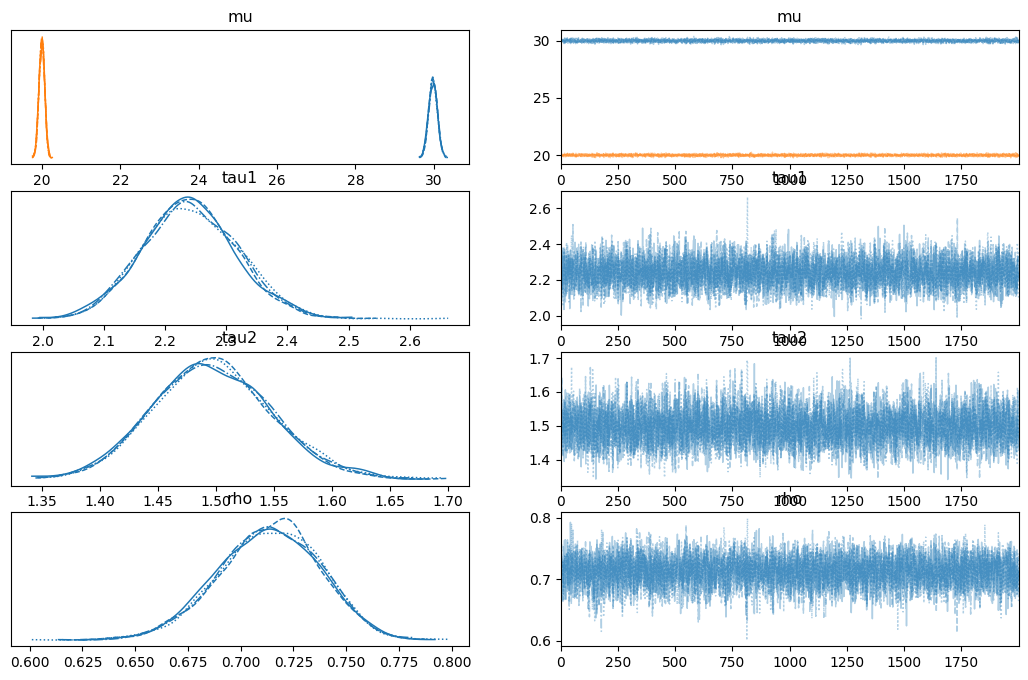

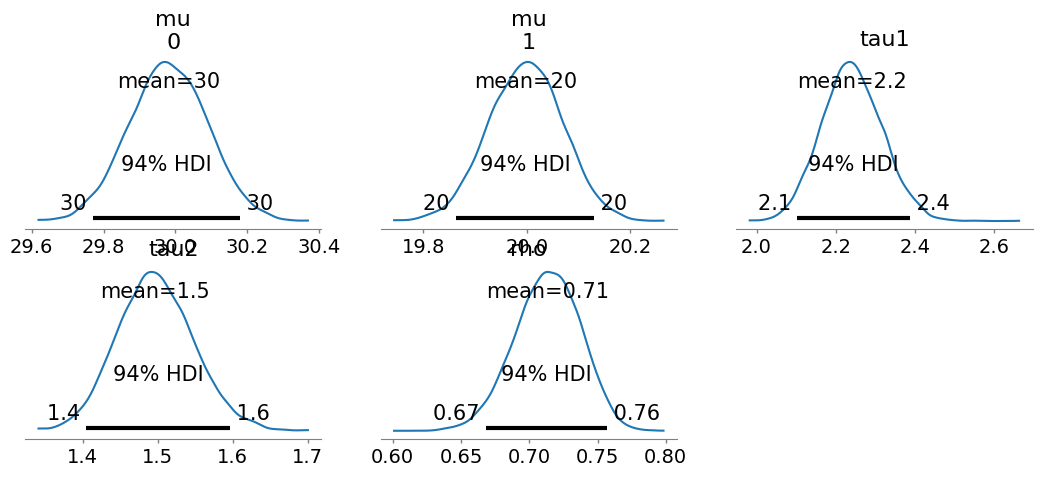

In [6]:
# Convertir la salida de cmdstanpy a un objeto InferenceData
idata = az.from_cmdstanpy(fit)

az.plot_trace(idata, var_names=["mu","tau1",'tau2', 'rho'], figsize=(13,8))
plt.show()

# Graficar el posterior de lambda
az.plot_posterior(idata, var_names=["mu",'tau1','tau2','rho'], figsize=(13,5))
plt.show()

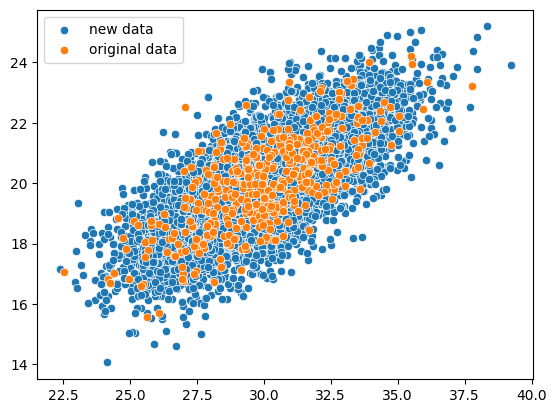

In [7]:
y_new_samples = fit.stan_variable("y_new")

sns.scatterplot(x=y_new_samples[:,0], y=y_new_samples[:,1], label='new data')
sns.scatterplot(x=np.array(samples)[:,0], y=np.array(samples)[:,1], label='original data')
plt.show()